# Michelin Rated Restaurants in France - Analysis

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Visualisation functions
from Functions.functions_visualisation import (dataframe_info, filter_dataframe,
                                               plot_choropleth, plot_area_info)

In [3]:
# Analysis functions
from Functions.functions_analysis import (plot_high_correlations, print_overview_stats, plot_boxplots, 
                                          find_extreme_departments, plot_side_by_side)

----
## We load in the department and *arrondissement* GeoJSON data

In [4]:
# Load GeoJSON departmental data
departments = gpd.read_file("../../data/France/department_restaurants.geojson")
print(departments.columns.tolist())

['code', 'department', 'capital', 'region', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants', 'GDP_millions(€)', 'GDP_per_capita(€)', 'poverty_rate(%)', 'average_annual_unemployment_rate(%)', 'average_net_hourly_wage(€)', 'municipal_population', 'population_density(inhabitants/sq_km)', 'area(sq_km)', 'locations', 'geometry']


In [5]:
# For pair plots we remove the individual 'star' counts and drop least interesting columns for brevity
dept_short = departments.drop(columns=['bib_gourmand', '1_star', '2_star', '3_star', 'starred_restaurants',
                                       'municipal_population', 'GDP_millions(€)', 'area(sq_km)'])

In [6]:
dataframe_info(dept_short)

GeoDataFrame.
Unique Regions: 13
Unique Departments: 96

Shape: (96, 12)


,code,department,capital,region,total_stars,GDP_per_capita(€),poverty_rate(%),average_annual_unemployment_rate(%),average_net_hourly_wage(€),population_density(inhabitants/sq_km),locations,geometry
0,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,7,25425.63,10.5,5.5,15.34,114.2,"{'Bib': [[46.30794, 4.92875], [46.3846303, 5.3...","POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,Laon,Hauts-de-France,0,22699.26,18.0,10.5,13.92,71.9,"{'Bib': None, '1': None, '2': None, '3': None}","POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,Moulins,Auvergne-Rhône-Alpes,2,24667.13,15.3,7.7,13.63,45.7,"{'Bib': [[46.2356555, 3.4258809], [46.1248938,...","POLYGON ((3.03207 46.79491, 3.03424 46.79080, ..."


----

In [7]:
# Load GeoJSON arrondissement data
arrondissements = gpd.read_file("../../data/France/arrondissement_restaurants.geojson")
print(arrondissements.columns.tolist())

['code', 'arrondissement', 'department_num', 'department', 'capital', 'region', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)', 'locations', 'geometry']


In [8]:
# For pair plots we remove the individual 'star' counts and drop least interesting columns for brevity
arron_short = arrondissements.drop(columns=['bib_gourmand', '1_star', '2_star', '3_star',
                                            'starred_restaurants', 'municipal_population'])

In [9]:
dataframe_info(arron_short)

GeoDataFrame.
Unique Regions: 13
Unique Departments: 96
Unique Arrondissements: 320

Shape: (320, 12)


,code,arrondissement,department_num,department,capital,region,total_stars,population_density(inhabitants/sq_km),poverty_rate(%),average_net_hourly_wage(€),locations,geometry
0,01001,Belley,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,1,77.9,10.2,15.30,"{'1': [[46.0070045, 5.3605085]], '2': None, '3...","POLYGON ((5.12174 45.81118, 5.12665 45.81392, ..."
1,01002,Bourg-en-Bresse,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,5,118.4,8.8,15.65,"{'1': [[46.4340961, 4.9390332], [46.2987913, 4...","POLYGON ((4.98022 46.51520, 4.98355 46.51539, ..."
2,01003,Gex,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,1,247.8,12.4,15.32,"{'1': [[46.3626315, 6.0258533]], '2': None, '3...","POLYGON ((6.06401 46.41623, 6.06730 46.41494, ..."


----
&nbsp;
# Analysis at Regional Level

Focus on mainland France and therefore Corsica is dropped

In [10]:
regions = dept_short.region.unique().tolist()
regions.remove("Corse")
print(f"Unique Regions:\n{regions}")

Unique Regions:
['Auvergne-Rhône-Alpes', 'Hauts-de-France', "Provence-Alpes-Côte d'Azur", 'Grand Est', 'Occitanie', 'Normandie', 'Nouvelle-Aquitaine', 'Centre-Val de Loire', 'Bourgogne-Franche-Comté', 'Bretagne', 'Pays de la Loire', 'Île-de-France']


In [11]:
print(dept_short.columns.tolist())

['code', 'department', 'capital', 'region', 'total_stars', 'GDP_per_capita(€)', 'poverty_rate(%)', 'average_annual_unemployment_rate(%)', 'average_net_hourly_wage(€)', 'population_density(inhabitants/sq_km)', 'locations', 'geometry']


In [12]:
column_dictionary = {'total_stars': 'michelin_stars',
                    'GDP_per_capita(€)': 'per_capita_GDP',
                    'poverty_rate(%)': 'poverty_rate',
                    'average_annual_unemployment_rate(%)': 'unemployment_rate',
                    'average_net_hourly_wage(€)': 'net_wage',
                    'population_density(inhabitants/sq_km)': 'pop_density',
                    }

Renaming columns for clarity and concise visualization purposes.

In [13]:
# Departments
dept_short.rename(columns=column_dictionary, inplace=True)
departments.rename(columns=column_dictionary, inplace=True)

In [14]:
# Arrondissements
arron_short.rename(columns=column_dictionary, inplace=True)
arrondissements.rename(columns=column_dictionary, inplace=True)

----
&nbsp;
## Partition data into Northern/Southern France

In [15]:
south_dept = filter_dataframe(dept_short, regions=['provence', 'occitanie', 'aquitaine', 'auvergne rhone alpes'])
south_arron = filter_dataframe(arron_short, regions=['provence', 'occitanie', 'aquitaine', 'auvergne rhone alpes'])

In [16]:
# Finding northern regions
s_regions = set(south_dept.region.unique().tolist())
all_regions = set(regions)
n_regions = list(all_regions - s_regions)
print(n_regions)

['Bourgogne-Franche-Comté', 'Centre-Val de Loire', 'Île-de-France', 'Normandie', 'Bretagne', 'Hauts-de-France', 'Grand Est', 'Pays de la Loire']


In [17]:
# We exclude Paris
no_paris = filter_dataframe(dept_short, exclude_departments='Paris')

In [18]:
north = filter_dataframe(dept_short, regions=n_regions)
north_no_paris = filter_dataframe(no_paris, regions=n_regions)

`north` & `north_no_paris` are useful DataFrames for further analysis

----
&nbsp;
# Narrowing scope to Southern France

## Pair Plots

We seek an overview of relationships between multiple numerical variables

Departments: 43


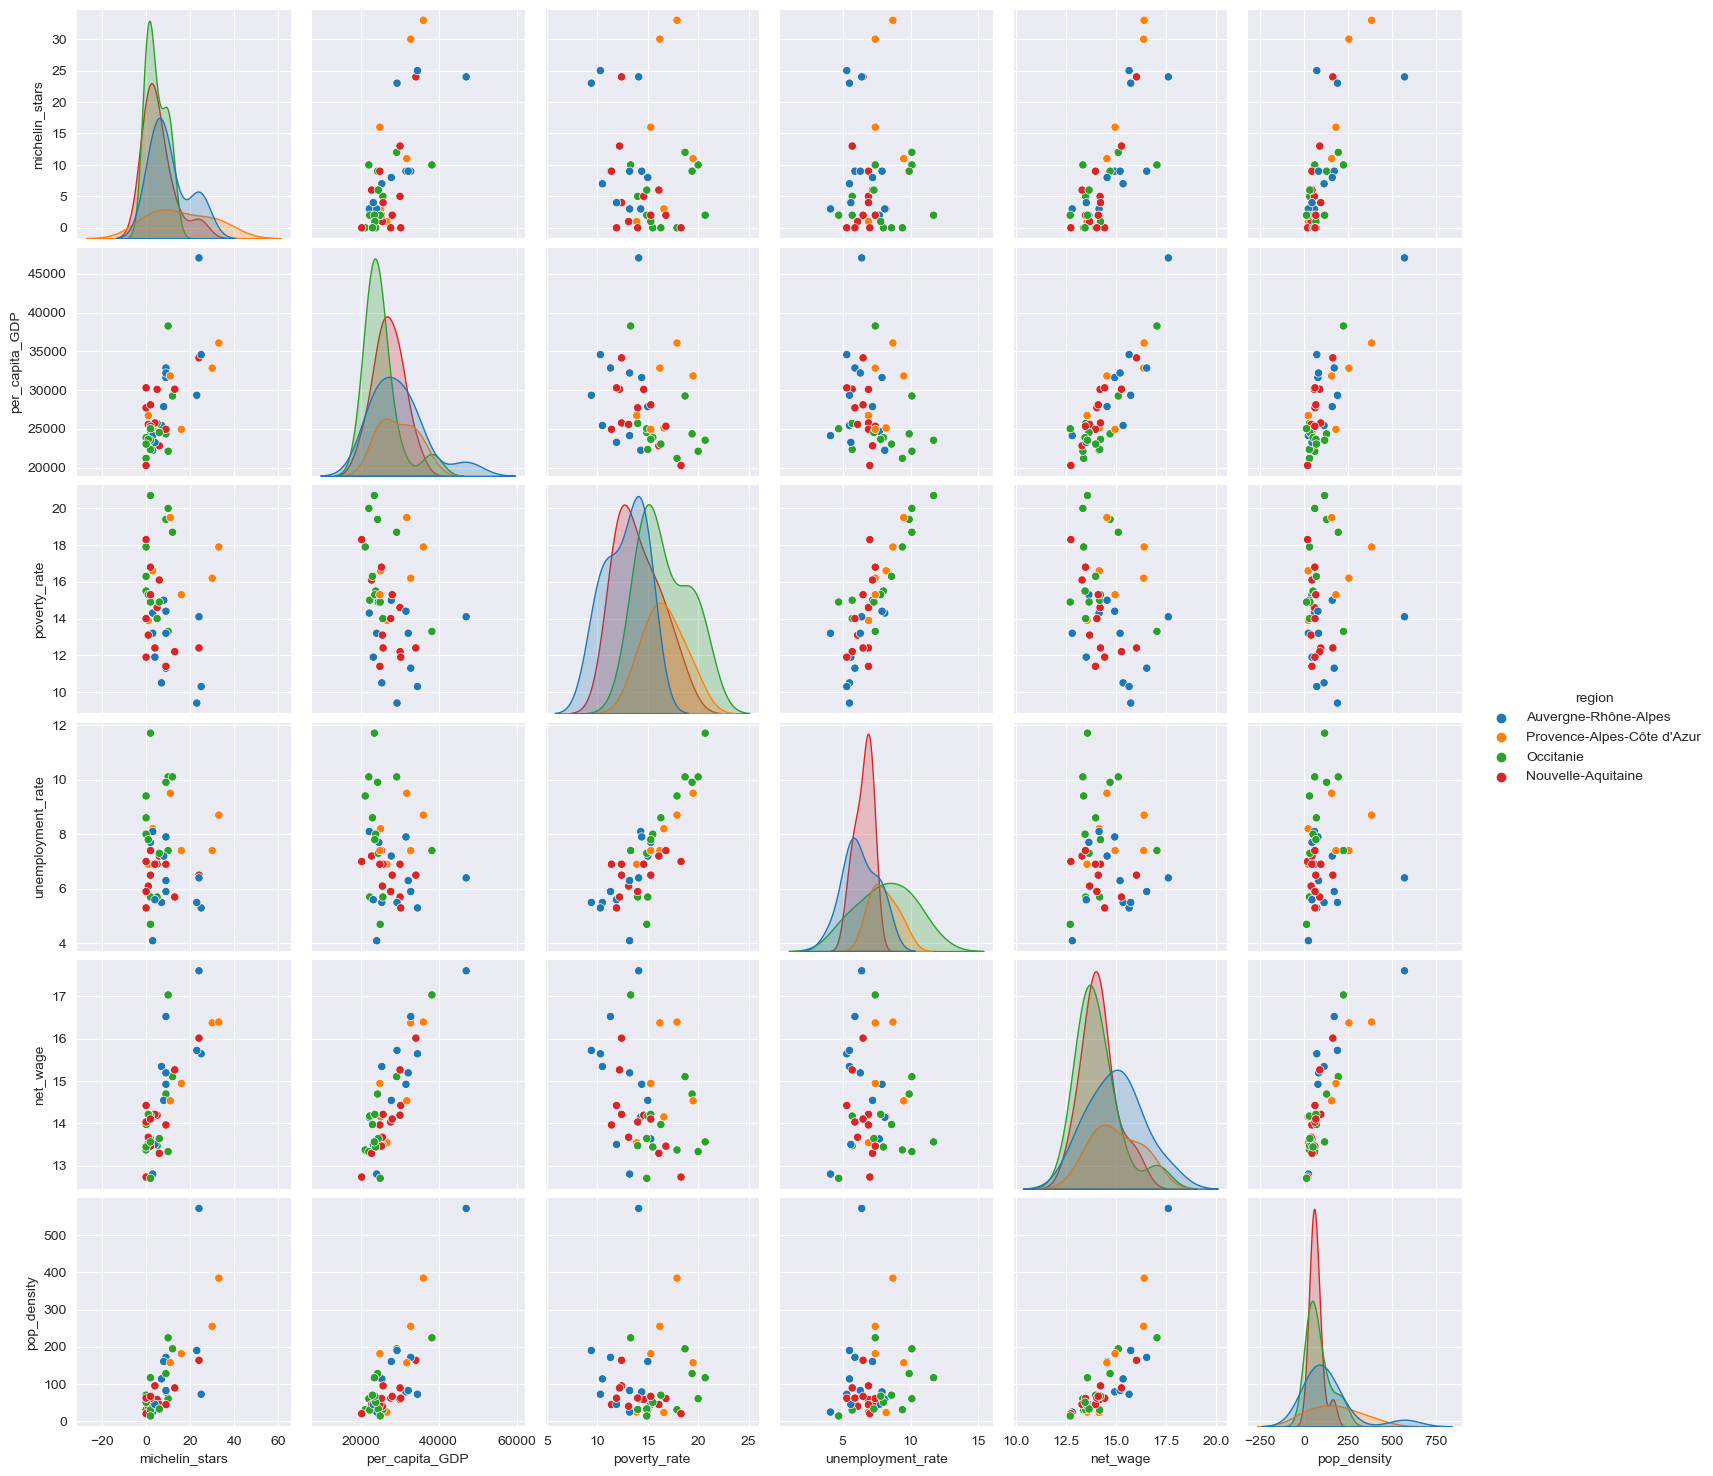

In [19]:
print(f"Departments: {south_dept.department.nunique()}")
sns.pairplot(south_dept, hue='region')

- *Auvergne-Rhône-Alpes* and *Provence-Alpes-Côte d'Azur* regions are prominently represented by five to six departments. These departments notably cluster towards the upper end in `michelin_stars` across most variable distributions. In contrast, departments from the *Occitanie* region tend to cluster towards the lower spectrum for `michelin_stars`
&nbsp;
- *Occitanie* features prominently on the higher end of the `poverty_rate` and `unemployment_rate` scales. While these patterns are evident, pinpointing whether the same departments persistently appear in these clusters across all variables would require a closer examination.
&nbsp;
- *Provence-Alpes-Côte d'Azur* stands out with the broadest spread in individual variable distributions, indicating a diverse range of values within this region.

While these patterns provide valuable insights, a deeper validation at the regional level is essential to confirm these preliminary findings.

We explore a pairplot at the *arrondissement* level. We are not in possession of `per_capita_GDP` or `unemployment_rate` data at this level of granularity

Arrondissements: 134


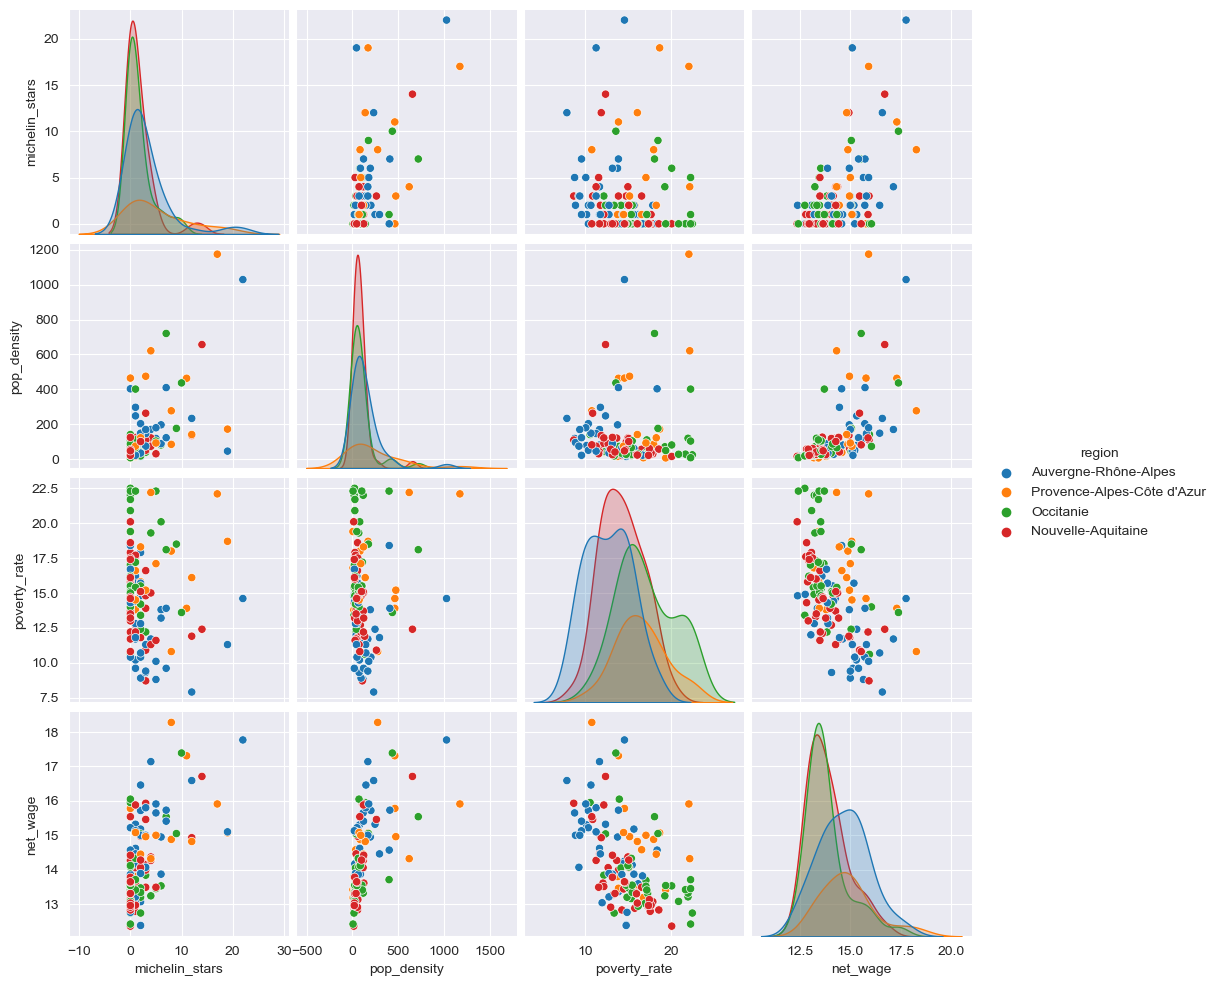

In [20]:
print(f"Arrondissements: {south_arron.arrondissement.nunique()}")
sns.pairplot(south_arron, hue='region')

There appears to be a bi-modal `poverty_rate` distribution for *Occitanie* which suggests there are a number of departments with a relatively high poverty rate.

----
&nbsp;
## Heatmaps

Visualising pairwise correlations above/below a certain threshold

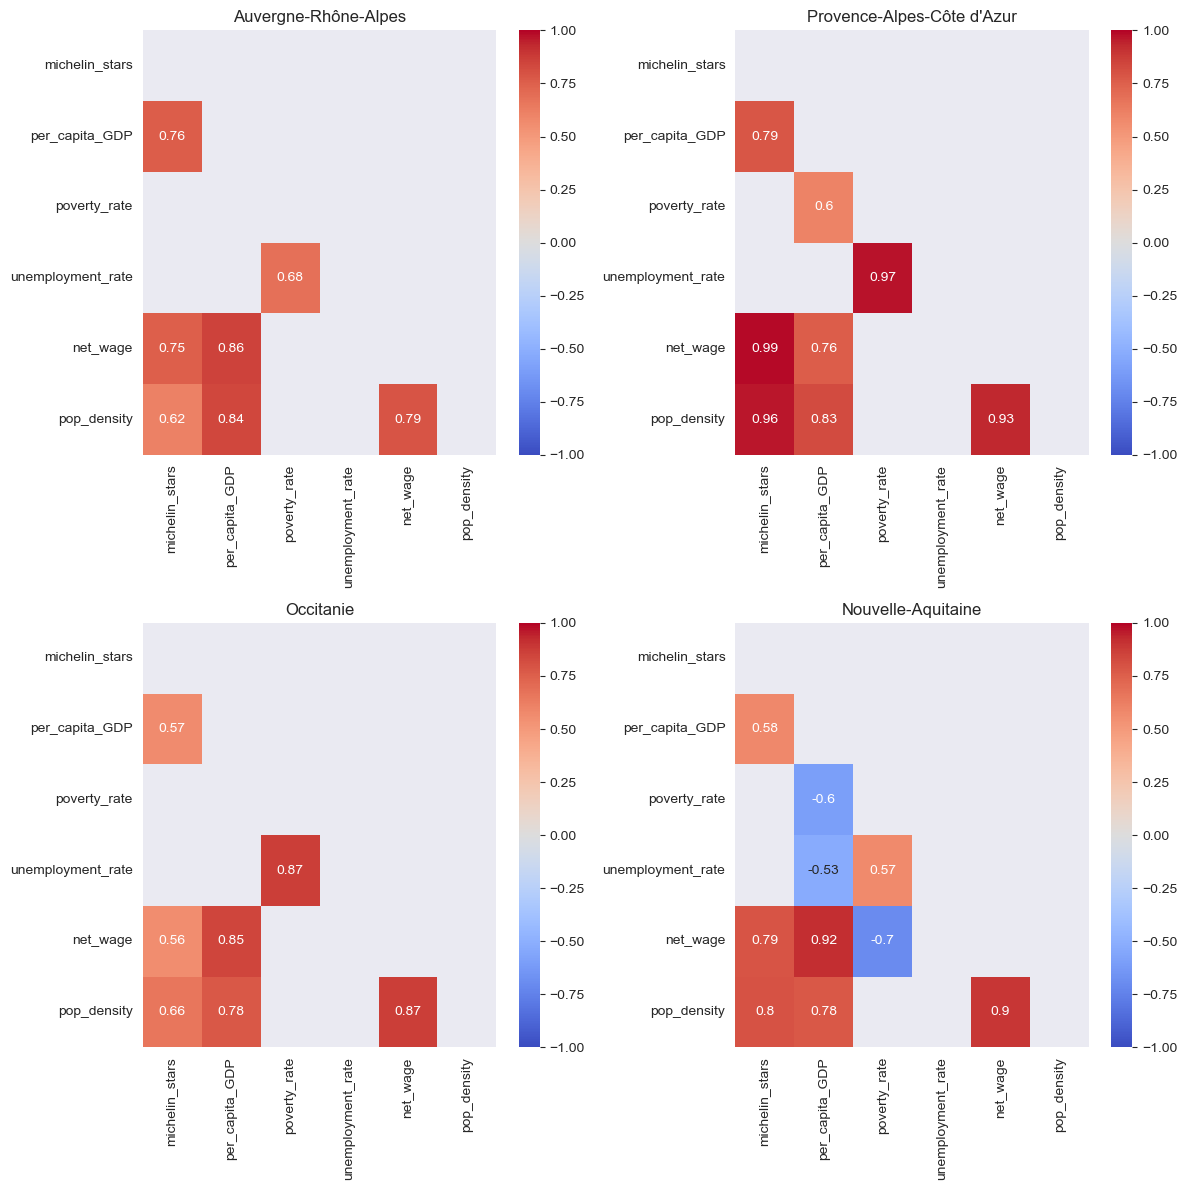

In [21]:
# We plot the correlation coefficients above a certain threshold
# I define my threshold for 'moderate correlation'
south_corr = plot_high_correlations(south_dept, level='regional', threshold=0.5)

Table of how we'll interpret Pearson's coefficient $r$ in the above heatmap
&nbsp;

| Range of $r$ | Absolute Value | Interpretation          |
|:------------:|:--------------:|:-----------------------:|
|  0.9 to 1.0  |   0.9 to 1.0   | Very Strong Correlation|
|  0.7 to 0.9  |   0.7 to 0.9   | Strong Correlation      |
|  0.5 to 0.7  |   0.5 to 0.7   | Moderate Correlation    |
|  0.3 to 0.5  |   0.3 to 0.5   | Weak Correlation        |
|  0.0 to 0.3  |   0.0 to 0.3   | Very Weak Correlation   |
|      0       |       0        | No Correlation          |
&nbsp;
This analysis does not seek to prove anything and is exploratory in nature. It aims to reveal patterns, relationships, or anomalies that could form the basis of further investigations. 

#### *Provence-Alpes-Côte d'Azur*
- There's a moderate positive correlation between `per_capita_GDP` | `poverty_rate` which could suggest economic inequality. There are cities in this region known for luxury and tourism which can create pockets of high GDP alongside areas of poverty. 
- `unemployment_rate` | `poverty_rate` are strongly correlated which is an expected relationship.
- The high correlation between `michelin_stars` | `net_wage` (0.989997) is intriguing. Does a higher concentration of Michelin-starred restaurants influence the average net wage, or is it the other way around, where areas with higher net wages attract more high-end dining establishments?

#### *Occitanie*
- `unemployment_rate` | `poverty_rate` are strongly correlated along with `net_wage` | `per_capita_GDP`.
- the strong positive correlation between `net_wage` | `pop_density` (0.868679) suggests that areas with higher population density might offer better wage opportunities. This is an expected observation, as dense areas often have cities or business hubs.

#### *Nouvelle-Aquitaine*

- There's a moderate negative correlation between 
    - `per_capita_GDP` | `poverty_rate`,
    - `per_capita_GDP` | `unemployment_rate`
    - `net_wage` | `poverty_rate` 
which are all typical yet essential economic health pointers.
  
- `net_wage` | `per_capita_GDP` show a strong positive correlation which could hint at a more even distribution of income or a balanced economy where high GDP doesn't necessarily mean just a few pockets of wealth.


### We investigate `population_density`, `per_capita_GDP`, `poverty_rate`, `unemployment_rate`, `net_wage` & `michelin_stars` at the departmental level across regions.

In [22]:
cols_of_interest = ['michelin_stars', 'per_capita_GDP', 'poverty_rate',
                    'unemployment_rate', 'net_wage', 'pop_density']

The following tables provide statistical summaries of various socio-economic factors for the different regions of Southern France. These statistics give us insights into the region's overall economic health and the standard of living.

In [23]:
overview = south_dept.groupby('region')[cols_of_interest].describe()
print_overview_stats(overview)

Region: Auvergne-Rhône-Alpes
----------------------------
Statistic | Michelin_stars | Per_capita_gdp | Poverty_rate | Unemployment_rate | Net_wage | Pop_density
-------------------------------------------------------------------------------------------------------
Count     | 12.00          | 12.00          | 12.00        | 12.00             | 12.00    | 12.00      
Mean      | 10.50          | 29595.04       | 12.74        | 6.29              | 14.96    | 134.99     
Std       | 8.53           | 6876.40        | 2.00         | 1.22              | 1.35     | 147.47     
Min       | 2.00           | 22224.31       | 9.40         | 4.10              | 12.80    | 25.20      
25%       | 3.75           | 24529.08       | 11.10        | 5.50              | 14.01    | 56.12      
50%       | 8.50           | 28593.16       | 13.20        | 6.10              | 15.05    | 81.15      
75%       | 12.50          | 32361.43       | 14.33        | 7.33              | 15.66    | 163.58     
Max   

##### Key Insights: 

*Auvergne-Rhône-Alpes* has the highest mean for Michelin stars, suggesting a strong gastronomic presence. Additionally, with a high GDP, this is a relatively prosperous region. The unemployment rate and poverty rate show areas of potential concern.

*Nouvelle-Aquitaine*: Interestingly, even though the GDP is less compared to Auvergne-Rhône-Alpes, the net wage seems comparable. However, the poverty rate is a bit higher.

*Occitanie* has the highest unemployment rate, which aligns with its high poverty rate. Its GDP per capita is lower than the other regions. It's Michelin presence is the lowest in the South of France. It would be interesting to explore the distribution of michelin stars.

*Provence-Alpes-Côte d'Azur*: This region has the second-highest Michelin stars on average but has fewer departments. The unemployment and poverty rates are considerable, even with a high GDP, suggesting some level of economic disparity.

#### Visualising the distribution of the above data

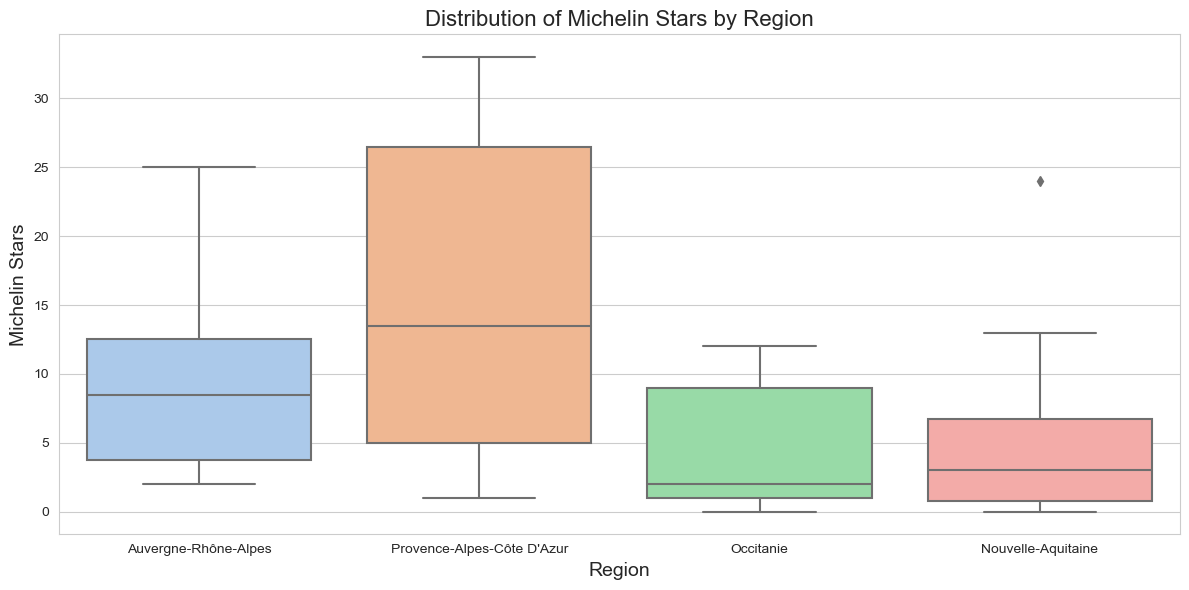

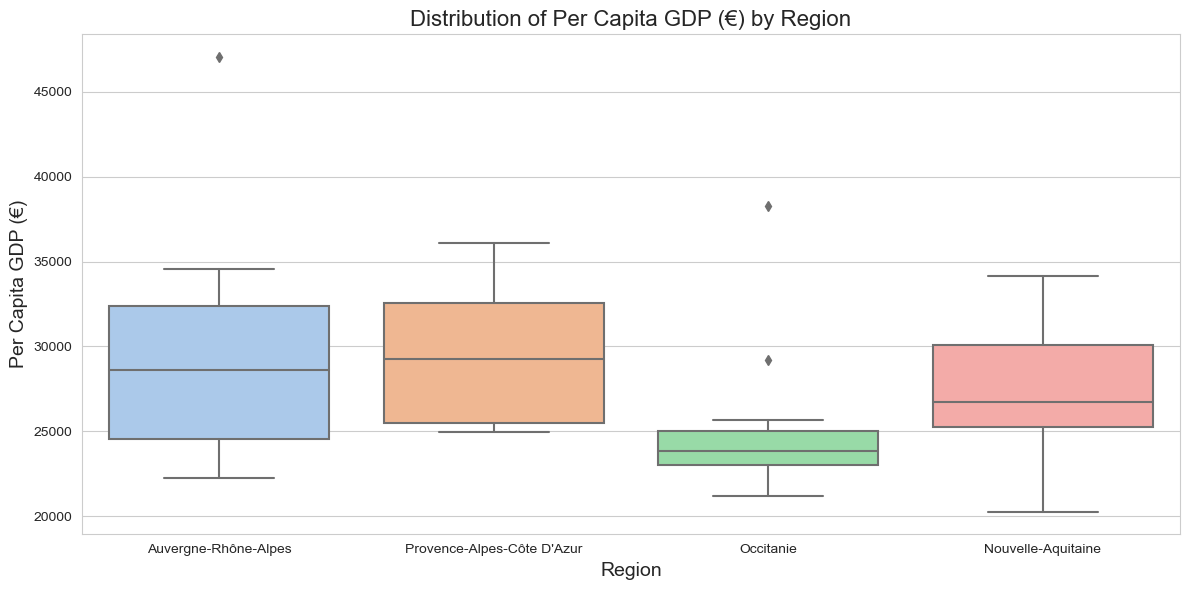

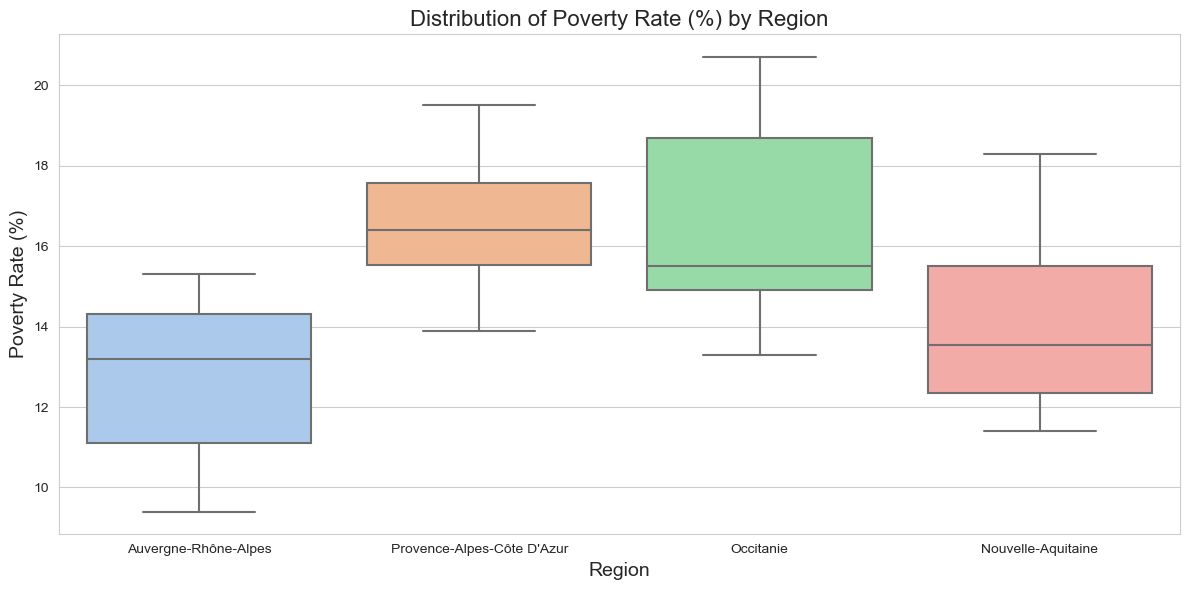

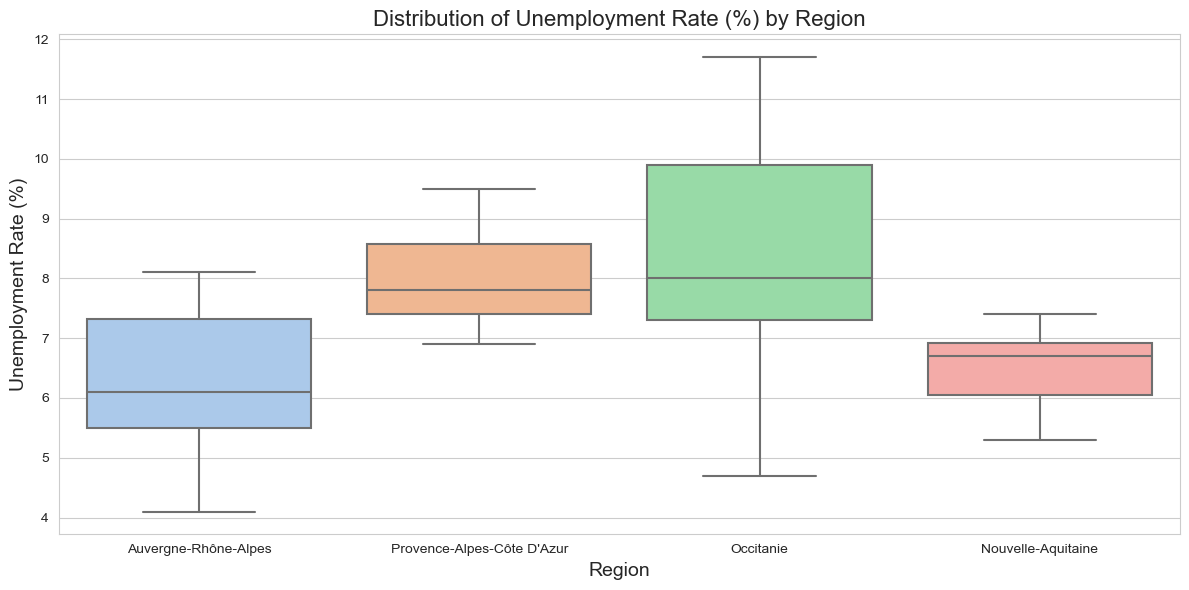

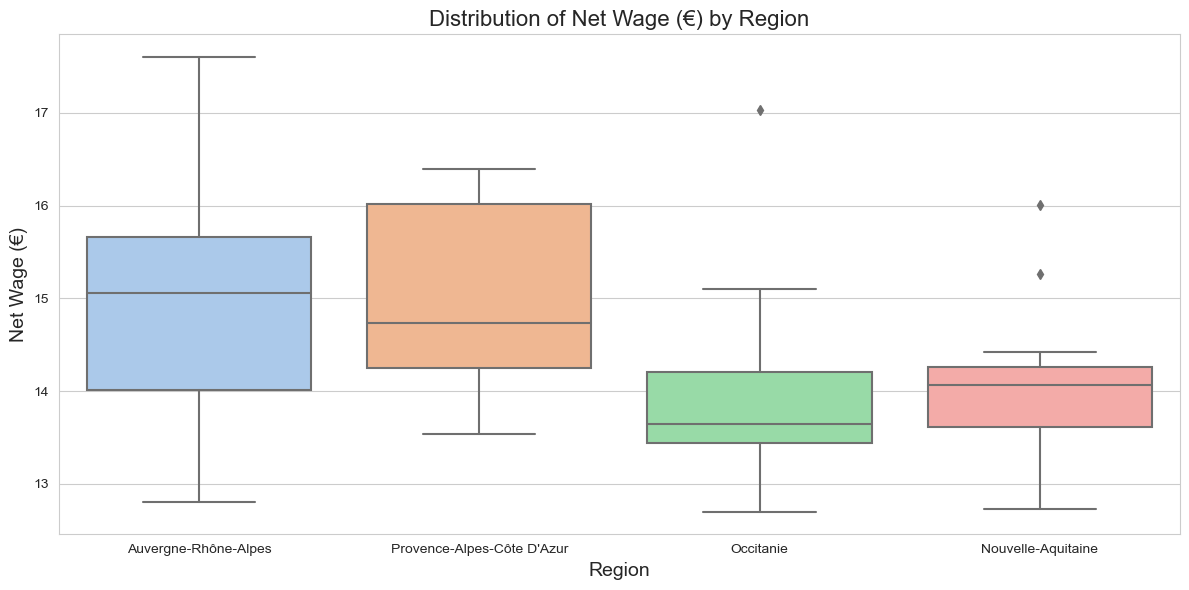

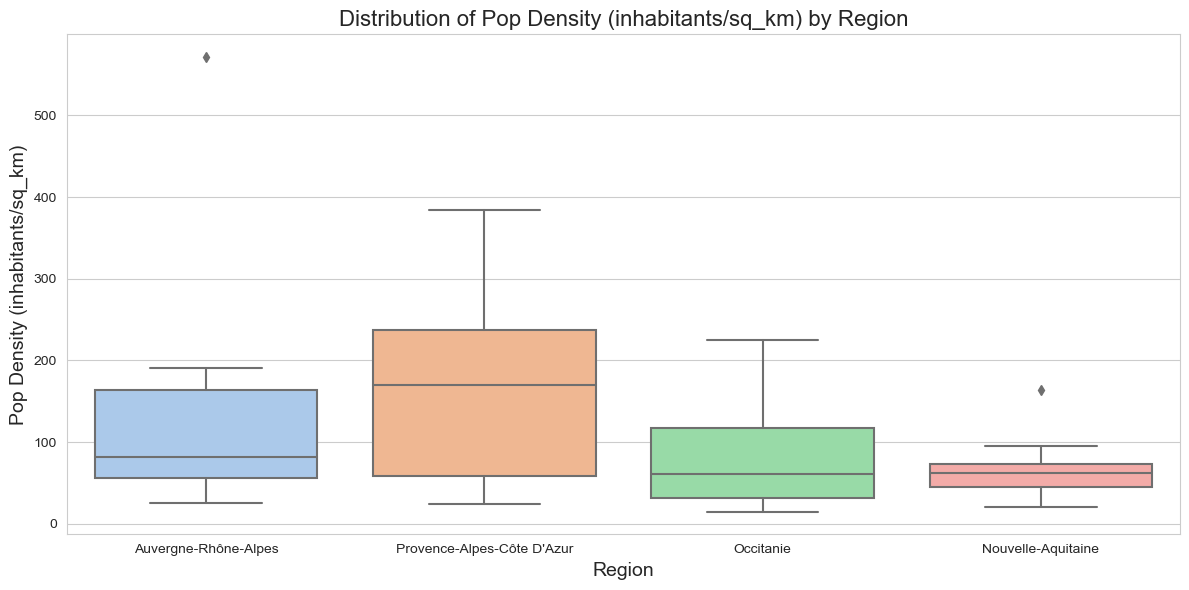

In [24]:
plot_boxplots(south_dept, cols_of_interest)

We find the min/max department within each region for each column of interest

In [53]:
find_extreme_departments(south, cols_of_interest)

Region: Auvergne-Rhône-Alpes

michelin_stars
	Max: Savoie (73) = 25 
	Min: Allier (03) = 2 

per_capita_GDP
	Max: Rhône (69) = 47048.24 
	Min: Ardèche (07) = 22224.31 

poverty_rate
	Max: Allier (03) = 15.3 %
	Min: Haute-Savoie (74) = 9.4 %

unemployment_rate
	Max: Ardèche (07) = 8.1 %
	Min: Cantal (15) = 4.1 %

net_wage
	Max: Rhône (69) = 17.6 €
	Min: Cantal (15) = 12.8 €

pop_density
	Max: Rhône (69) = 571.3 inhabitants/sq_km
	Min: Cantal (15) = 25.2 inhabitants/sq_km

--------------------------------------------------
Region: Provence-Alpes-Côte d'Azur

michelin_stars
	Max: Bouches-du-Rhône (13) = 33 
	Min: Hautes-Alpes (05) = 1 

per_capita_GDP
	Max: Bouches-du-Rhône (13) = 36072.35 
	Min: Var (83) = 24932.52 

poverty_rate
	Max: Vaucluse (84) = 19.5 %
	Min: Hautes-Alpes (05) = 13.9 %

unemployment_rate
	Max: Vaucluse (84) = 9.5 %
	Min: Hautes-Alpes (05) = 6.9 %

net_wage
	Max: Bouches-du-Rhône (13) = 16.39 €
	Min: Hautes-Alpes (05) = 13.54 €

pop_density
	Max: Bouches-du-Rhône (13

To better understand these results, we find the weighted mean `poverty_rate`, `unemployment_rate` and `net_wage` across France
$$
\mathrm{Weighted \ Mean} = \frac{\sum_i (\mathrm{value}_i \times \mathrm{weight}_i)}{\sum_i \mathrm{weight}_i}
$$

In [57]:
print(departments.columns.tolist())

['code', 'department', 'capital', 'region', 'bib_gourmand', '1_star', '2_star', '3_star', 'michelin_stars', 'starred_restaurants', 'GDP_millions(€)', 'per_capita_GDP', 'poverty_rate', 'unemployment_rate', 'net_wage', 'municipal_population', 'pop_density', 'area(sq_km)', 'locations', 'geometry']


In [56]:
# Compute the weighted means
france_poverty = (departments['poverty_rate'] * departments['municipal_population']).sum() /\
                        departments['municipal_population'].sum()

france_unemployment = (departments['unemployment_rate'] * departments['municipal_population']).sum() /\
                        departments['municipal_population'].sum()

france_wage = (departments['net_wage'] * departments['municipal_population']).sum() /\
                        departments['municipal_population'].sum()

print(f"Weighted mean poverty rate across France: {france_poverty:.2f}%")
print(f"Weighted mean unemployment rate across France: {france_unemployment:.2f}%")
print(f"Weighted mean hourly wage across France: {france_wage:.2f}€")

Weighted mean poverty rate across France: 14.43%
Weighted mean unemployment rate across France: 7.13%
Weighted mean hourly wage across France: 16.05€


Average Hourly wage gives insights into earning potential and can hint at the type of prevalent industries in an area

A high poverty rate could indicate economic distress, lack of job opportunities, or other socioeconomic challenges.

Unemployment rate is a direct indicator of job market health. A higher rate can signify economic downturns, structural challenges in the economy, or mismatch of skills in the job market.

Examining departmental extrema, we notice *Pyrénées-Orientales* (66) in Occitanie and *Vaucluse* (84) in PACA have poverty and unemployment rates well above the national average.

----
&nbsp;
## Narrowing scope to *Provence-Alpes-Côte d'Azur* & *Occitanie*

#### We use the GeoDataFrame `departments` to create choropleth maps

In [58]:
print(departments.columns.tolist())

['code', 'department', 'capital', 'region', 'bib_gourmand', '1_star', '2_star', '3_star', 'michelin_stars', 'starred_restaurants', 'GDP_millions(€)', 'per_capita_GDP', 'poverty_rate', 'unemployment_rate', 'net_wage', 'municipal_population', 'pop_density', 'area(sq_km)', 'locations', 'geometry']


----
&nbsp;
### Provence-Alpes-Côte d'Azur

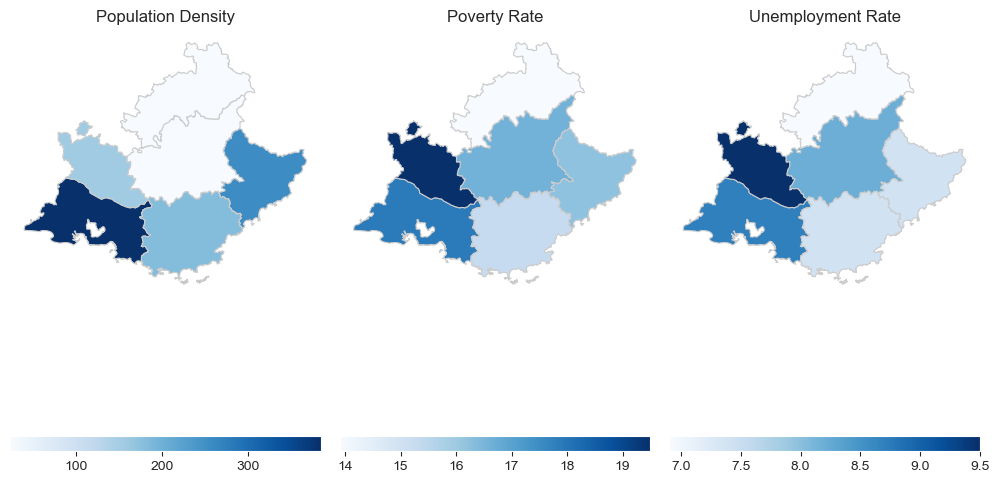

In [59]:
paca = departments[departments['region'] == "Provence-Alpes-Côte d'Azur"]
plot_multi_choropleth(paca, ['pop_density', 'poverty_rate', 'unemployment_rate'],
                          ['Population Density', 'Poverty Rate', 'Unemployment Rate'])

In [60]:
cols_of_interest = ['poverty_rate', 'unemployment_rate', 'net_wage', 'per_capita_GDP']
french_means = {'poverty': france_poverty,
                'unemployment': france_unemployment,
                'wage': france_wage}

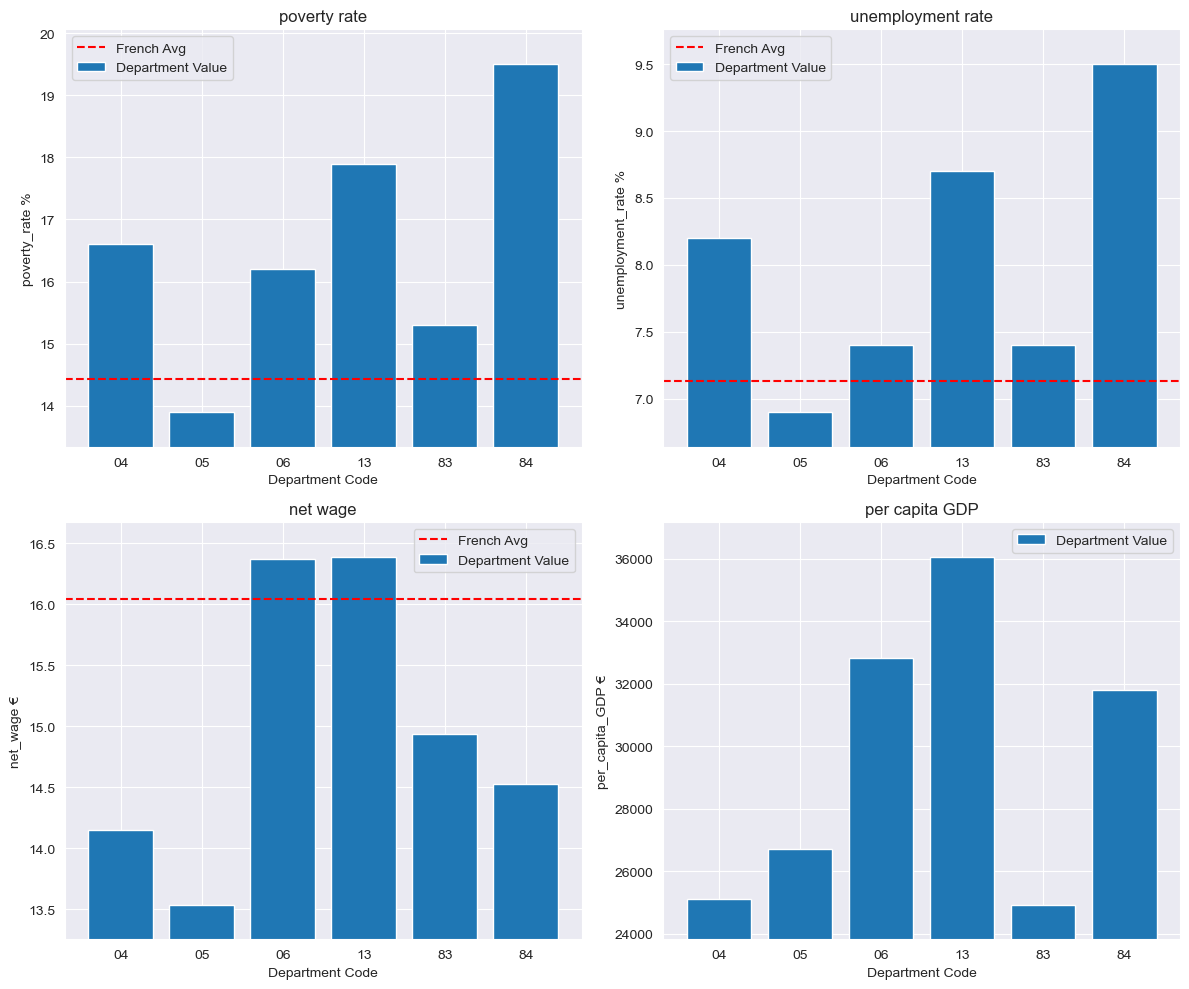

In [61]:
plot_side_by_side(paca, cols_of_interest, french_means)

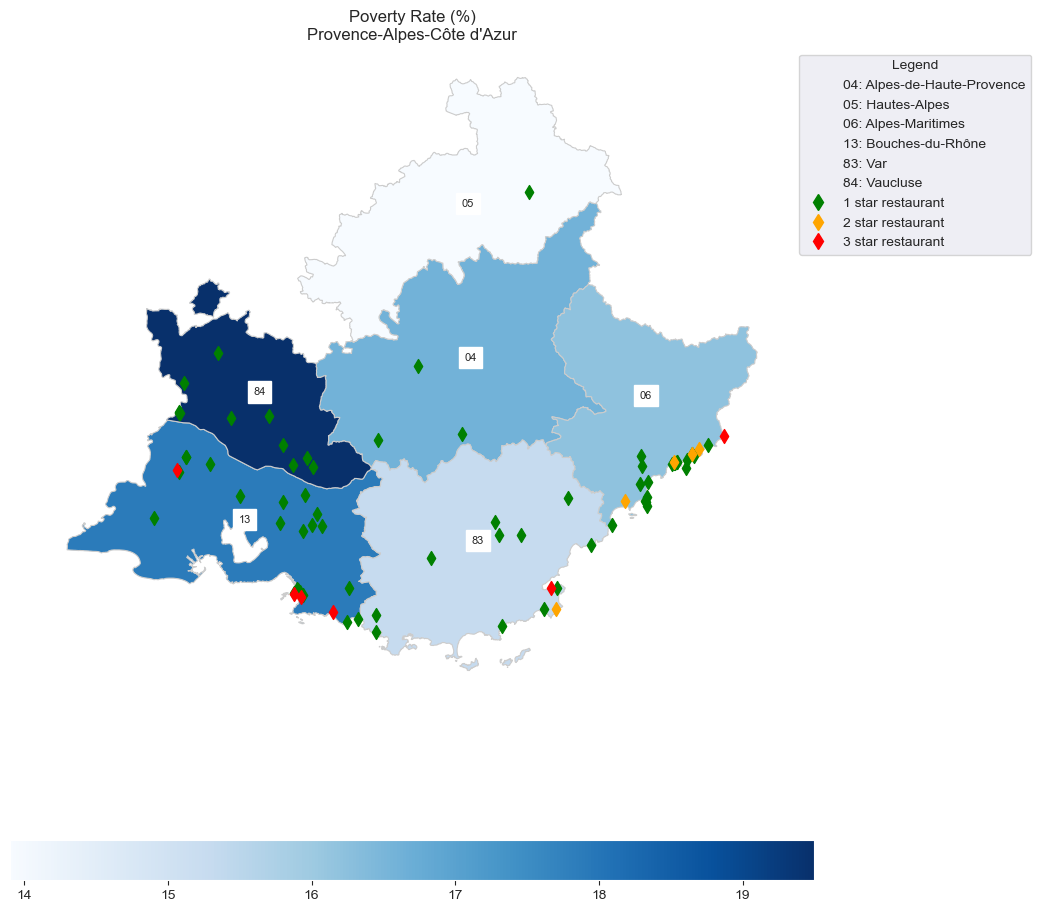

In [26]:
plot_choropleth(paca, 'poverty_rate', 'Poverty Rate (%)', restaurants=True, regional=True)

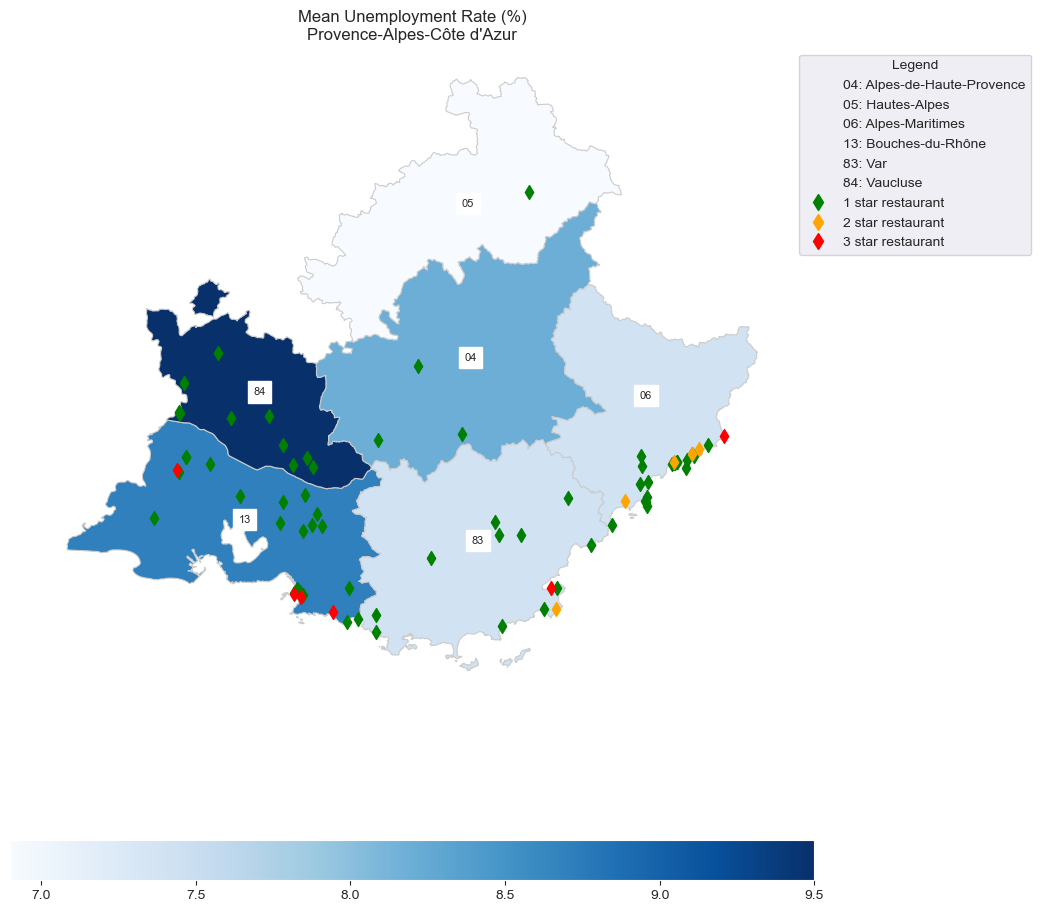

In [27]:
plot_choropleth(paca, 'unemployment_rate', 'Mean Unemployment Rate (%)', restaurants=True, regional=True)

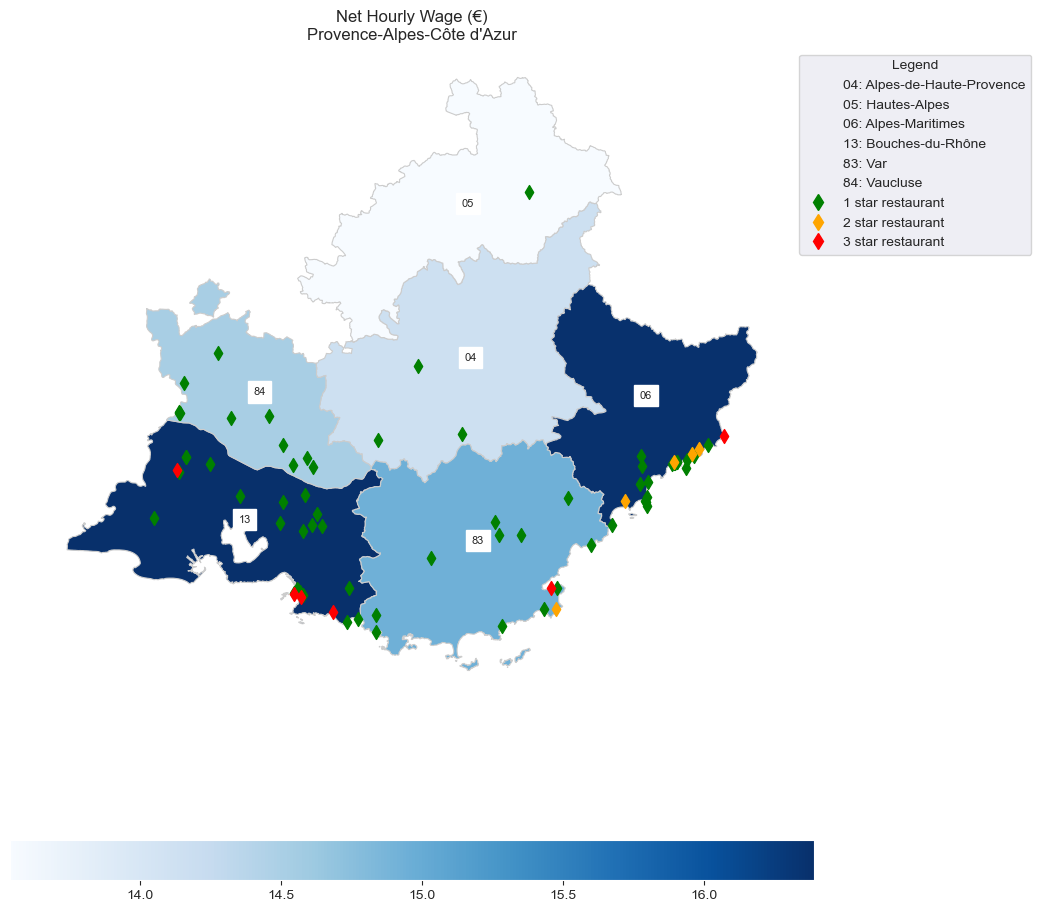

In [28]:
plot_choropleth(paca, 'net_wage', 'Net Hourly Wage (€)', restaurants=True, regional=True)

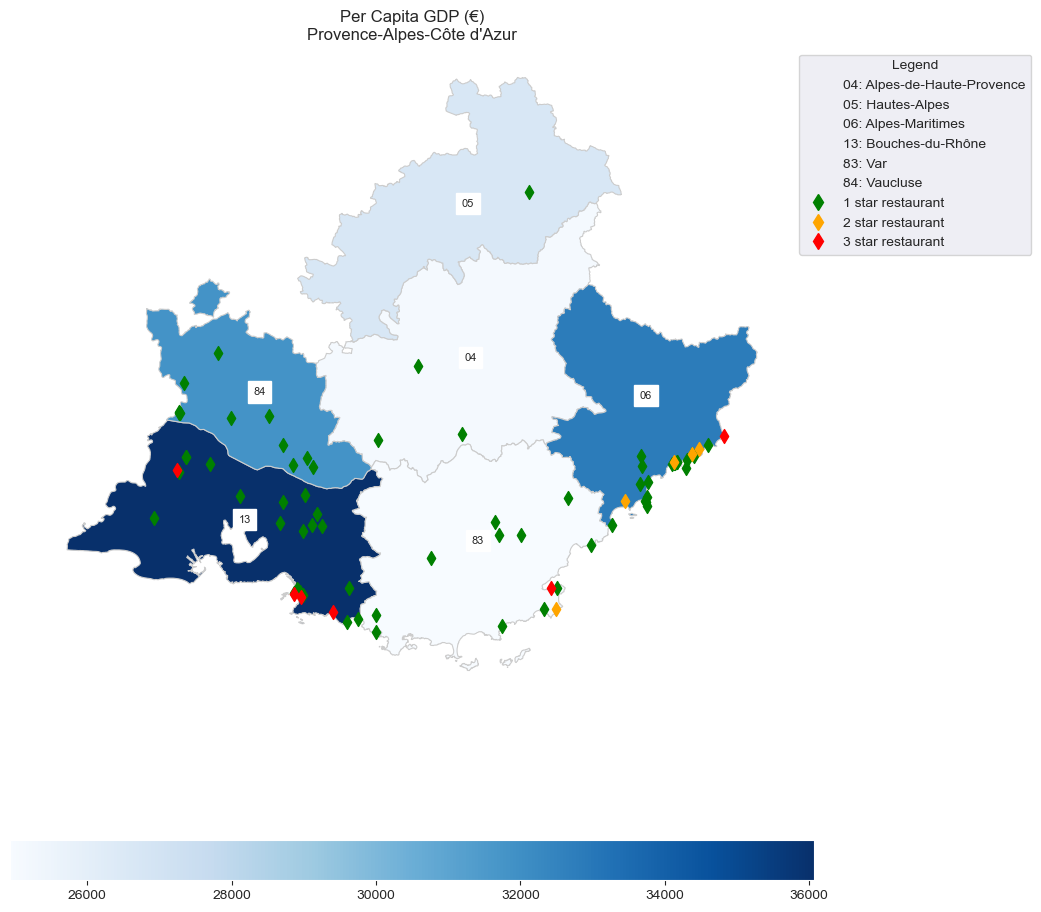

In [29]:
plot_choropleth(paca, 'per_capita_GDP', 'Per Capita GDP (€)', restaurants=True, regional=True)

----
&nbsp;
### Occitanie

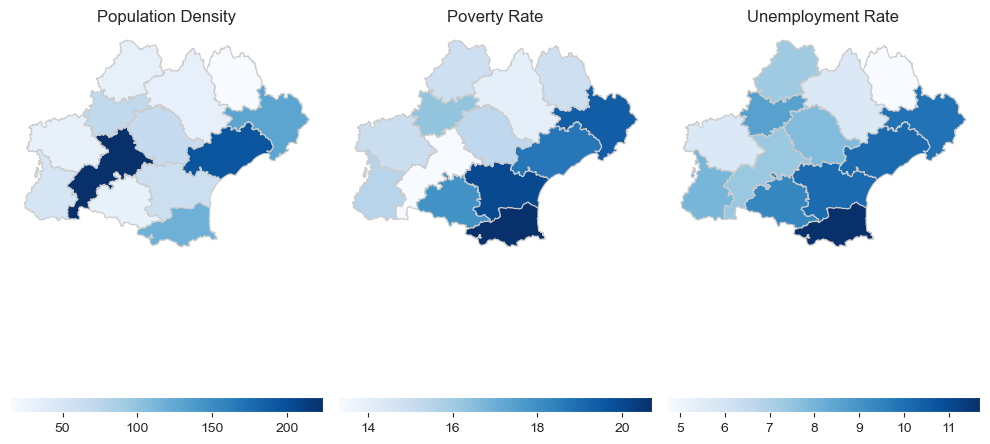

In [30]:
occitanie = departments[departments['region'] == "Occitanie"]
plot_multi_choropleth(occitanie, ['pop_density', 'poverty_rate', 'unemployment_rate'],
                          ['Population Density', 'Poverty Rate', 'Unemployment Rate'])

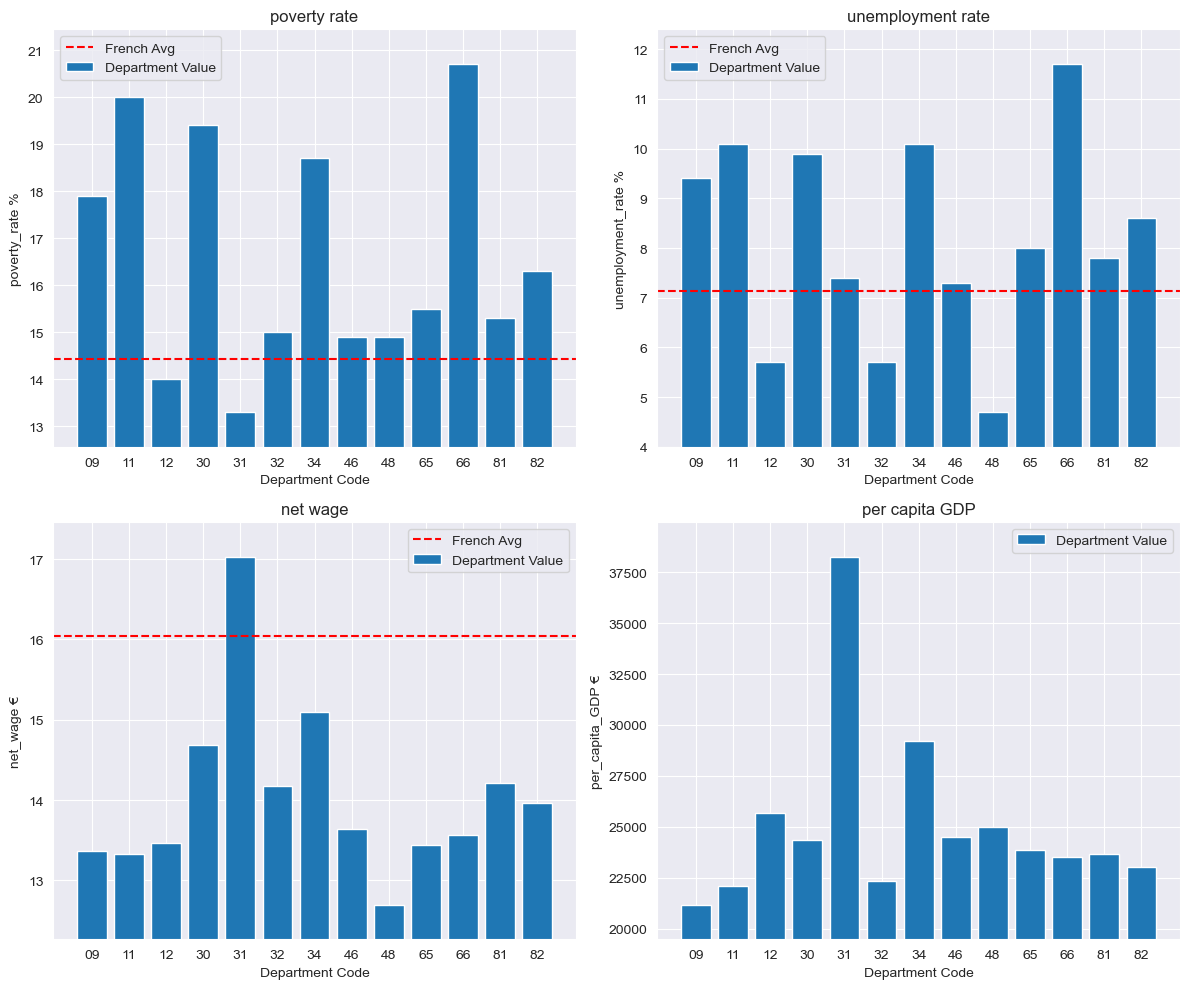

In [31]:
plot_side_by_side(occitanie, cols_of_interest, french_means)

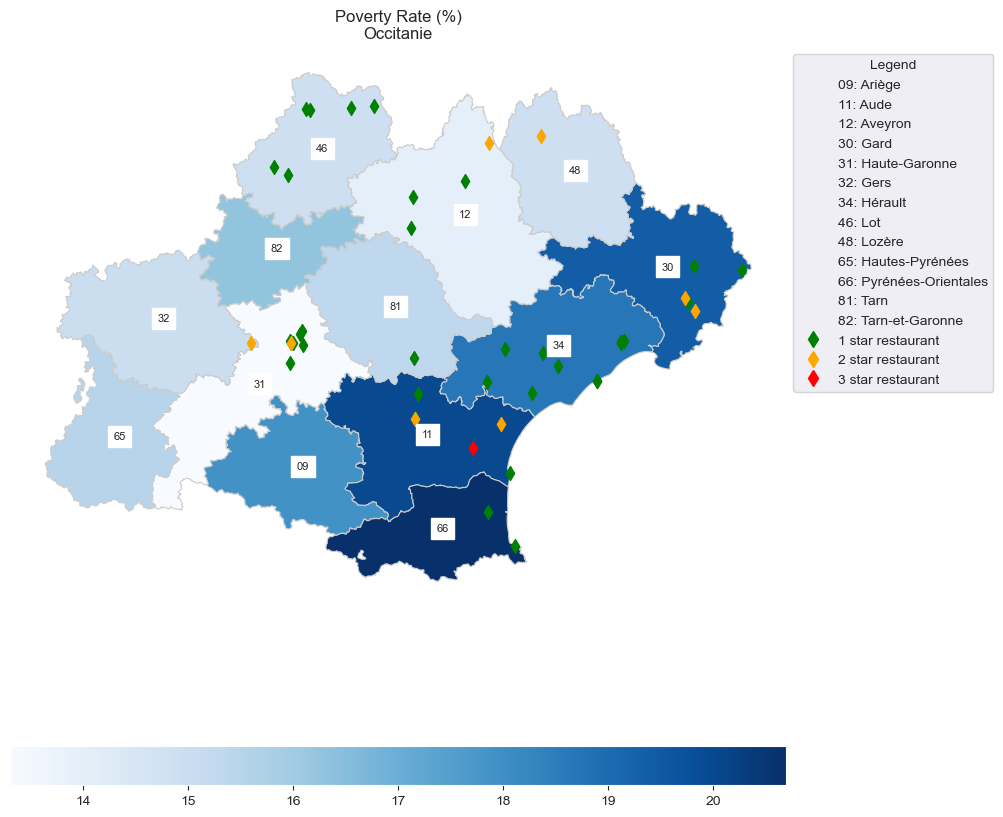

In [33]:
plot_choropleth(occitanie, 'poverty_rate', 'Poverty Rate (%)', restaurants=True, regional=True)

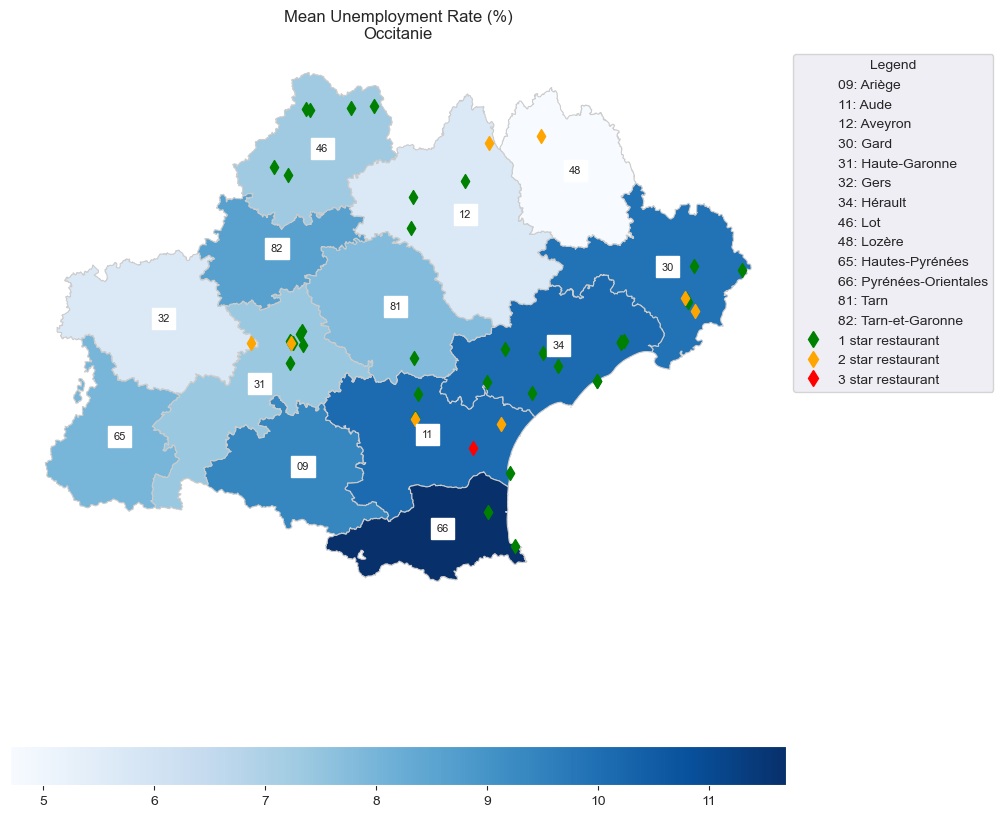

In [34]:
plot_choropleth(occitanie, 'unemployment_rate', 'Mean Unemployment Rate (%)', restaurants=True, regional=True)

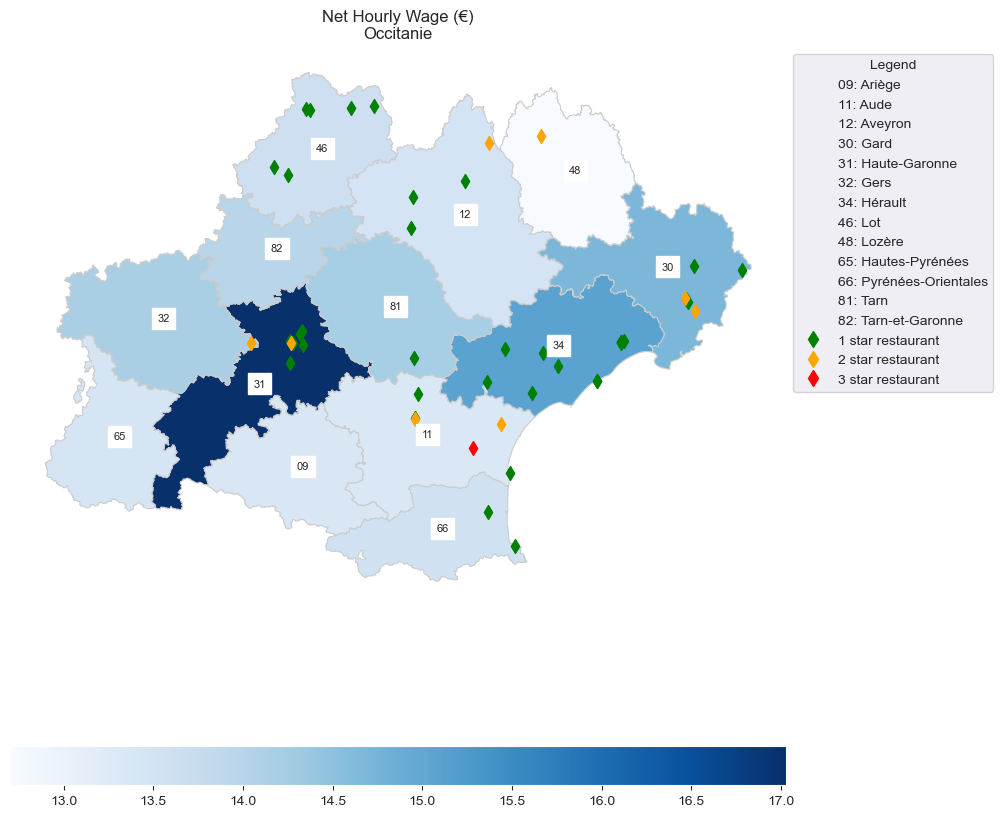

In [35]:
plot_choropleth(occitanie, 'net_wage', 'Net Hourly Wage (€)', restaurants=True, regional=True)

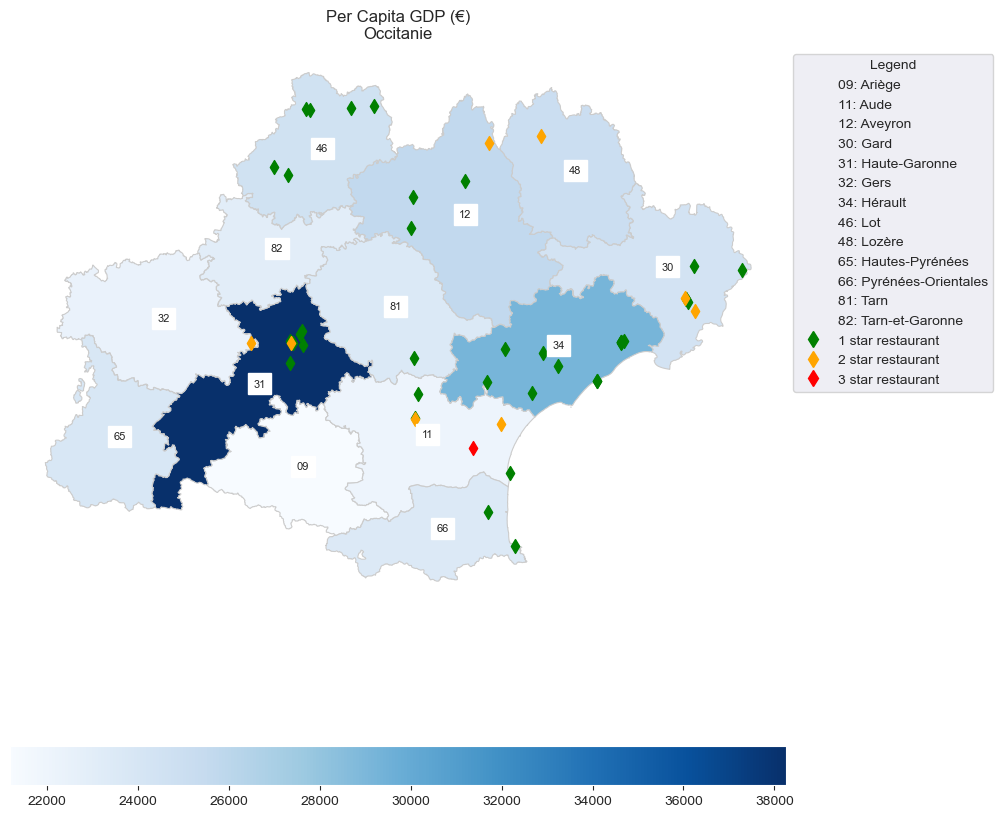

In [36]:
plot_choropleth(occitanie, 'per_capita_GDP', 'Per Capita GDP (€)', restaurants=True, regional=True)